# Load data

In [58]:
import matplotlib.pyplot as plt
import numpy as np
import json
import datetime
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LinearSegmentedColormap

red_to_light_green = LinearSegmentedColormap.from_list('RedLightGreen', ['red', 'lightgreen'])

def load_detailed_data(file_path):
    with open(file_path, 'r') as f:
        data = [json.loads(line) for line in f]
    return data

# Treat data

In [59]:
def prepare_plot_data(data, change_index):
    change = data[change_index]
    
    timestamps = np.array(change['timestamp']) + 9 * 3600  
    readable_timestamps = [datetime.datetime.fromtimestamp(ts).strftime('%H:%M:%S.%f')[:-3] for ts in timestamps]
    
    vehicle_focus_vel = np.array(change['vehicle_focus_vel'])
    vehicle_focus_local_y = np.array(change['vehicle_focus_local_y']) * 0.3048  # 英尺转米

    vehicle_before_preceding_vel = np.array(change['vehicle_before_preceding_vel']) if change['before_preceding_id'] != 0 else np.array([])
    vehicle_before_preceding_local_y = np.array(change['vehicle_before_preceding_local_y']) * 0.3048 if change['before_preceding_id'] != 0 else np.array([])
    
    vehicle_before_following_vel = np.array(change['vehicle_before_following_vel']) if change['before_following_id'] != 0 else np.array([])
    vehicle_before_following_local_y = np.array(change['vehicle_before_following_local_y']) * 0.3048 if change['before_following_id'] != 0 else np.array([])
    
    vehicle_after_preceding_vel = np.array(change['vehicle_after_preceding_vel']) if change['after_preceding_id'] != 0 else np.array([])
    vehicle_after_preceding_local_y = np.array(change['vehicle_after_preceding_local_y']) * 0.3048 if change['after_preceding_id'] != 0 else np.array([])
    
    vehicle_after_following_vel = np.array(change['vehicle_after_following_vel']) if change['after_following_id'] != 0 else np.array([])
    vehicle_after_following_local_y = np.array(change['vehicle_after_following_local_y']) * 0.3048 if change['after_following_id'] != 0 else np.array([])
    
    # 计算所有速度的全局最小值和最大值
    all_velocities = np.concatenate([
        vehicle_focus_vel, 
        vehicle_before_preceding_vel, 
        vehicle_before_following_vel, 
        vehicle_after_preceding_vel, 
        vehicle_after_following_vel
    ])
    global_min_vel = np.min(all_velocities)
    global_max_vel = np.max(all_velocities)
    
    return {
        'timestamps': readable_timestamps,
        'vehicle_focus': (vehicle_focus_local_y, vehicle_focus_vel),
        'before_preceding': (vehicle_before_preceding_local_y, vehicle_before_preceding_vel),
        'before_following': (vehicle_before_following_local_y, vehicle_before_following_vel),
        'after_preceding': (vehicle_after_preceding_local_y, vehicle_after_preceding_vel),
        'after_following': (vehicle_after_following_local_y, vehicle_after_following_vel),
        'global_min_vel': global_min_vel,
        'global_max_vel': global_max_vel,
        'before_change_timestamp': change['before_change_timestamp']
    }

# Set plotting environment

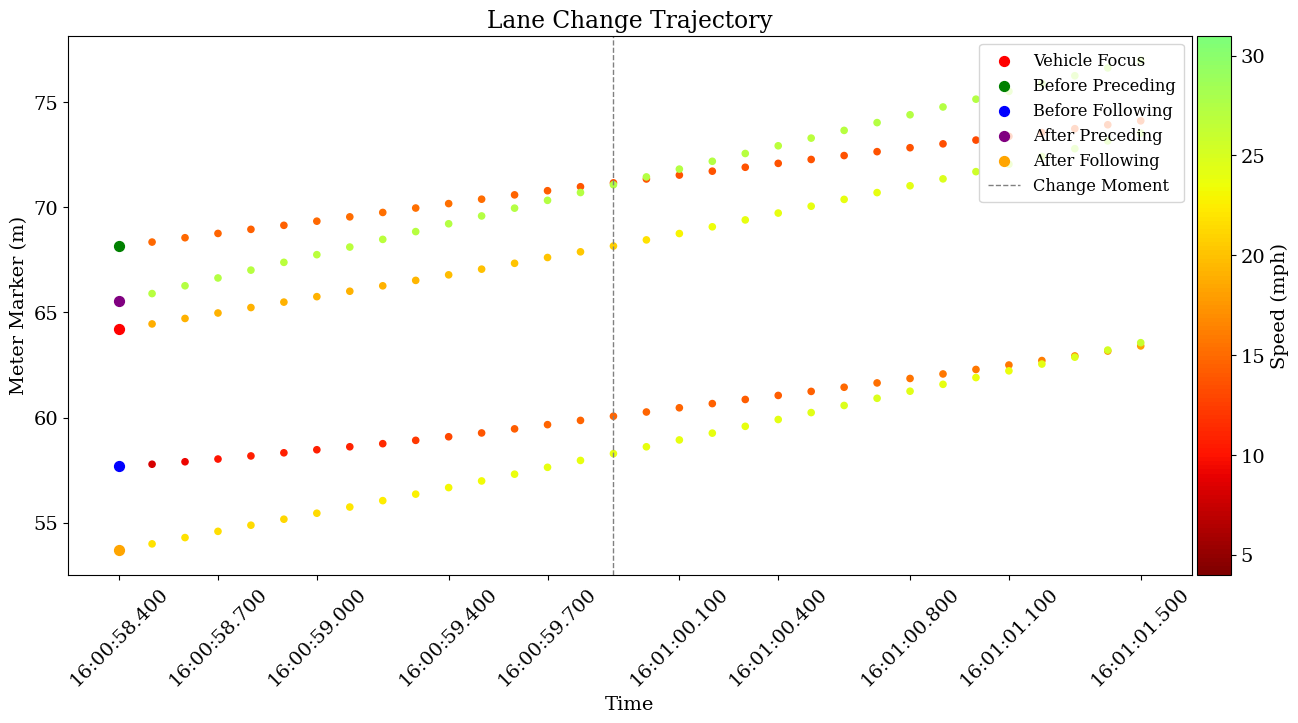

In [60]:
def setup_plot():
    plt.rc('font', family='serif', size=14)
    fig, ax = plt.subplots(figsize=(15, 7))  # 增加图像尺寸
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.05)

    # 定义颜色范围
    jet = plt.cm.jet
    colors = [jet(x) for x in np.linspace(1, 0.5, 256)]
    green_to_red = LinearSegmentedColormap.from_list('GreenToRed', colors, N=256)
    
    return fig, ax, green_to_red, cax

def plot_lane_change(plot_data, buffer=3):
    fig, ax, green_to_red, cax = setup_plot()
    colors = ['red', 'green', 'blue', 'purple', 'orange']
    labels = ['Vehicle Focus', 'Before Preceding', 'Before Following', 'After Preceding', 'After Following']

    # 获取全局最小值和最大值，并进行取整
    vmin = max(0, np.floor(plot_data['global_min_vel'] - buffer))
    vmax = np.ceil(plot_data['global_max_vel'] + buffer)

    def scatter_nonzero(ax, timestamps, y_values, velocities, color_index, label):
        non_zero_indices = [i for i, y in enumerate(y_values) if y != 0]
        if not non_zero_indices:
            return

        first_non_zero_index = non_zero_indices[0]
        ax.scatter(timestamps[first_non_zero_index], y_values[first_non_zero_index], c=colors[color_index], s=50, label=label)

        non_zero_timestamps = [timestamps[i] for i in non_zero_indices[1:]]
        non_zero_y_values = [y_values[i] for i in non_zero_indices[1:]]
        non_zero_velocities = [velocities[i] for i in non_zero_indices[1:]]

        sc = ax.scatter(non_zero_timestamps, non_zero_y_values, c=non_zero_velocities, cmap=green_to_red, vmin=vmin, vmax=vmax, s=20)
        return sc

    # 绘制变道车辆轨迹
    scatter_nonzero(ax, plot_data['timestamps'], plot_data['vehicle_focus'][0], plot_data['vehicle_focus'][1], 0, labels[0])

    # 绘制前后车辆轨迹
    scatter_nonzero(ax, plot_data['timestamps'], plot_data['before_preceding'][0], plot_data['before_preceding'][1], 1, labels[1])
    scatter_nonzero(ax, plot_data['timestamps'], plot_data['before_following'][0], plot_data['before_following'][1], 2, labels[2])
    scatter_nonzero(ax, plot_data['timestamps'], plot_data['after_preceding'][0], plot_data['after_preceding'][1], 3, labels[3])
    scatter_nonzero(ax, plot_data['timestamps'], plot_data['after_following'][0], plot_data['after_following'][1], 4, labels[4])

    # 设置x轴为可读格式
    ax.set_xticks(np.linspace(0, len(plot_data['timestamps']) - 1, num=10, dtype=int))
    ax.set_xticklabels(np.array(plot_data['timestamps'])[np.linspace(0, len(plot_data['timestamps']) - 1, num=10, dtype=int)], rotation=45)

    ax.set_xlabel('Time')
    ax.set_ylabel('Meter Marker (m)')
    ax.set_title('Lane Change Trajectory')
    
    # 绘制变道前的时间帧的竖直虚线
    before_change_readable = datetime.datetime.fromtimestamp(plot_data['before_change_timestamp'] + 9 * 3600).strftime('%H:%M:%S.%f')[:-3]
    ax.axvline(x=before_change_readable, color='grey', linestyle='--', linewidth=1, label='Change Moment')

    # 调整图例
    ax.legend(loc='upper right', fontsize='small', frameon=True, handlelength=2, borderpad=0.5)

    # 添加颜色映射条
    cbar = plt.colorbar(ax.collections[1], cax=cax)
    cbar.set_label('Speed (mph)')

    plt.show()

# 加载和准备数据
detailed_file = 'trajectories-0400-0415-detailed-lane-change.json'
data = load_detailed_data(detailed_file)
change_index = 79
plot_data = prepare_plot_data(data, change_index)

# 绘图
plot_lane_change(plot_data)